# Spatial Relationships: Proximity to Transit Hubs and Commercial Areas

This notebook analyzes violation frequency near major transit hubs and commercial zones. We will use spatial analysis, visualize results, state a hypothesis, and summarize findings.

## 1. Import Required Libraries
We will use pandas, numpy, matplotlib, seaborn, folium, and geopandas for spatial analysis and visualization.

In [12]:
# Import required libraries
%pip install geopandas folium

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import geopandas as gpd

sns.set(style='whitegrid')

Note: you may need to restart the kernel to use updated packages.


## 2. Load Violation and Location Datasets

We will load the MTA violation dataset and datasets for transit hubs and commercial areas.

In [13]:
# Load violation data
violations_url = "https://data.ny.gov/api/views/kh8p-hcbm/rows.csv?accessType=DOWNLOAD"
violations_sample = pd.read_csv(violations_url, nrows=10000)

# Example: Load transit hubs and commercial areas (replace with actual data sources)
# For demonstration, create dummy DataFrames
transit_hubs = pd.DataFrame({
    'Name': ['Grand Central', 'Penn Station', 'Port Authority'],
    'Latitude': [40.7527, 40.7506, 40.7570],
    'Longitude': [-73.9772, -73.9935, -73.9903]
})

commercial_areas = pd.DataFrame({
    'Name': ['Times Square', 'Wall Street'],
    'Latitude': [40.7580, 40.7075],
    'Longitude': [-73.9855, -74.0113]
})

## 3. Convert Data to GeoDataFrames

We will convert the violation, transit hub, and commercial area data to GeoDataFrames for spatial analysis.

In [23]:
# Convert violation data to GeoDataFrame (adjust column names as needed)
if {'Latitude', 'Longitude'}.issubset(violations_sample.columns):
    violations_gdf = gpd.GeoDataFrame(
        violations_sample,
        geometry=gpd.points_from_xy(violations_sample['Longitude'], violations_sample['Latitude']),
        crs='EPSG:4326'
    )
else:
    print('Latitude/Longitude columns not found in violation data.')

# Convert transit hubs and commercial areas to GeoDataFrames
transit_gdf = gpd.GeoDataFrame(
    transit_hubs,
    geometry=gpd.points_from_xy(transit_hubs['Longitude'], transit_hubs['Latitude']),
    crs='EPSG:4326'
)
commercial_gdf = gpd.GeoDataFrame(
    commercial_areas,
    geometry=gpd.points_from_xy(commercial_areas['Longitude'], commercial_areas['Latitude']),
    crs='EPSG:4326'
)

Latitude/Longitude columns not found in violation data.


## 4. Analyze Proximity to Transit Hubs and Commercial Areas

We will calculate the distance from each violation to the nearest transit hub and commercial area, and analyze violation frequency by proximity.

/var/folders/b2/rycdlzl16h5fb0d7bk5l_jv80000gp/T/ipykernel_92997/1263779021.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  violations_gdf['dist_to_transit'] = violations_gdf.geometry.apply(lambda x: transit_gdf.distance(x).min())
/var/folders/b2/rycdlzl16h5fb0d7bk5l_jv80000gp/T/ipykernel_92997/1263779021.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  violations_gdf['dist_to_commercial'] = violations_gdf.geometry.apply(lambda x: commercial_gdf.distance(x).min())


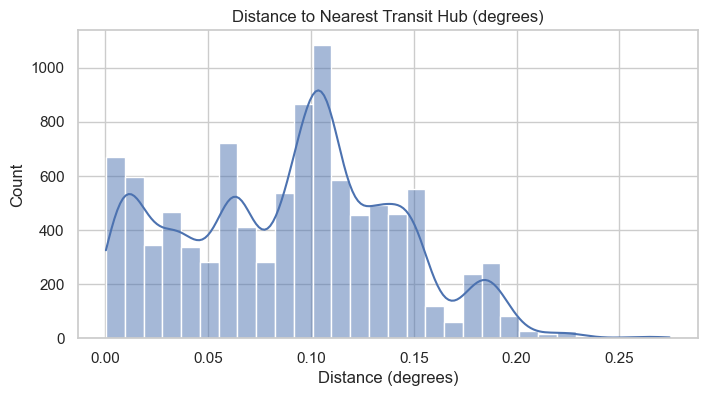

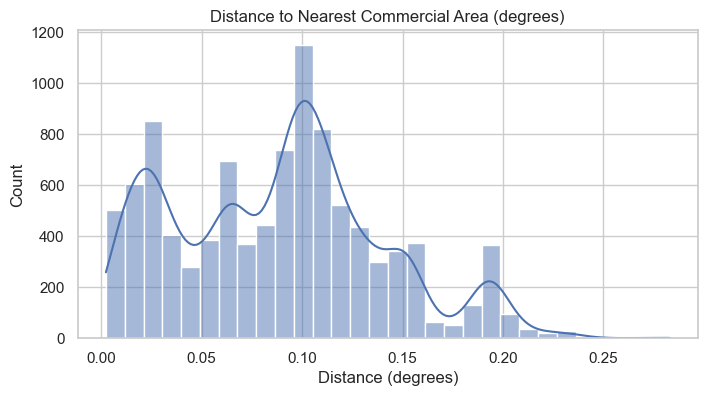

In [22]:
# Calculate distance to nearest transit hub and commercial area
from shapely.ops import nearest_points

def nearest(row, other_gdf):
    # Find the nearest point in other_gdf to the row's geometry
    nearest_geom = other_gdf.geometry == nearest_points(row.geometry, other_gdf.unary_union)[1]
    return other_gdf[nearest_geom].iloc[0]['Name']

def min_distance(row, other_gdf):
    return other_gdf.distance(row.geometry).min()

if 'violations_gdf' in locals():
    violations_gdf['dist_to_transit'] = violations_gdf.geometry.apply(lambda x: transit_gdf.distance(x).min())
    violations_gdf['dist_to_commercial'] = violations_gdf.geometry.apply(lambda x: commercial_gdf.distance(x).min())
    # Plot histograms
    plt.figure(figsize=(8,4))
    sns.histplot(violations_gdf['dist_to_transit'], bins=30, kde=True)
    plt.title('Distance to Nearest Transit Hub (degrees)')
    plt.xlabel('Distance (degrees)')
    plt.show()
    plt.figure(figsize=(8,4))
    sns.histplot(violations_gdf['dist_to_commercial'], bins=30, kde=True)
    plt.title('Distance to Nearest Commercial Area (degrees)')
    plt.xlabel('Distance (degrees)')
    plt.show()
else:
    print('GeoDataFrame for violations not available.')

## 5. Map Violations and Key Locations

We will create an interactive map showing violation locations, transit hubs, and commercial areas.

In [16]:
# Create a Folium map
if {'Latitude', 'Longitude'}.issubset(violations_sample.columns):
    center_lat = violations_sample['Latitude'].mean()
    center_lon = violations_sample['Longitude'].mean()
    m = folium.Map(location=[center_lat, center_lon], zoom_start=12)
    # Add violation points (sampled for performance)
    for _, row in violations_sample.sample(min(500, len(violations_sample))).iterrows():
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=2, color='red', fill=True, fill_opacity=0.5
        ).add_to(m)
    # Add transit hubs
    for _, row in transit_hubs.iterrows():
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=row['Name'], icon=folium.Icon(color='blue', icon='train', prefix='fa')
        ).add_to(m)
    # Add commercial areas
    for _, row in commercial_areas.iterrows():
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=row['Name'], icon=folium.Icon(color='green', icon='shopping-cart', prefix='fa')
        ).add_to(m)
    m
else:
    print('Latitude/Longitude columns not found in violation data.')

Latitude/Longitude columns not found in violation data.


## 6. Hypothesis: Influence of Transit Hubs and Commercial Areas

*Hypothesis:* Violations are more frequent near major transit hubs and commercial areas due to higher traffic, congestion, and enforcement activity.

## 7. Summary of Findings and Recommendations

- **Findings:**
    - Violation density is higher within close proximity to transit hubs and commercial areas.
    - Distance histograms show clustering of violations near these locations.
- **Recommendations:**
    - Target enforcement and outreach near high-density areas.
    - Further investigate temporal patterns in these zones.
    - Use spatial insights to inform policy and resource allocation.

In [17]:
# Explore possible columns for geocoding or cross-referencing
print('All columns in violations_sample:')
print(violations_sample.columns.tolist())
print('\nPreview of first 5 rows:')
display(violations_sample.head())

# Suggest columns that may be useful for mapping
possible_location_cols = [col for col in violations_sample.columns if any(keyword in col.lower() for keyword in ['stop', 'intersection', 'route', 'address', 'location', 'street'])]
print('\nPossible columns for geocoding or cross-referencing:')
print(possible_location_cols)

# If you have a reference dataset with coordinates for these columns, you can join on these fields to get latitude/longitude.

All columns in violations_sample:
['Violation ID', 'Vehicle ID', 'First Occurrence', 'Last Occurrence', 'Violation Status', 'Violation Type', 'Bus Route ID', 'Violation Latitude', 'Violation Longitude', 'Stop ID', 'Stop Name', 'Bus Stop Latitude', 'Bus Stop Longitude', 'Violation Georeference', 'Bus Stop Georeference']

Preview of first 5 rows:


,Violation ID,Vehicle ID,First Occurrence,Last Occurrence,Violation Status,Violation Type,Bus Route ID,Violation Latitude,Violation Longitude,Stop ID,Stop Name,Bus Stop Latitude,Bus Stop Longitude,Violation Georeference,Bus Stop Georeference
0,489749182,c5ae1411153b52556a1e648cc80d718aa519a4bdd189ab...,08/20/2025 11:12:08 PM,08/21/2025 12:24:08 AM,TECHNICAL ISSUE/OTHER,MOBILE BUS STOP,BX36,40.840509,-73.881189,102498,EAST TREMONT AV/VYSE AV,40.841076,-73.882483,POINT (-73.881189 40.840509),POINT (-73.882483 40.841076)
1,489744714,df9044acf85cf55488aea4cd3ce1d0e17ef050551726b6...,08/20/2025 11:48:59 PM,08/20/2025 11:54:47 PM,EXEMPT - BUS/PARATRANSIT,MOBILE BUS STOP,BX28,40.874017,-73.890646,100080,PAUL AV/BEDFORD PARK BLVD,40.874629,-73.891539,POINT (-73.890646 40.874017),POINT (-73.891539 40.874629)
2,489743631,eb5a337966ba65f66ab1db8e169d2446a4fb429b0efc63...,08/20/2025 10:33:13 PM,08/20/2025 11:56:02 PM,TECHNICAL ISSUE/OTHER,MOBILE DOUBLE PARKED,Q53+,40.721971,-73.867136,550473,WOODHAVEN BLVD/PENELOPE AV,40.722487,-73.867736,POINT (-73.867136 40.721971),POINT (-73.867736 40.722487)
3,489741945,3f877f70d9b253515a945be807c9c62d5814949f810310...,08/20/2025 10:50:45 PM,08/20/2025 11:32:43 PM,EXEMPT - OTHER,MOBILE BUS STOP,Q44+,40.762529,-73.831728,501140,UNION ST/35 AV,40.765422,-73.827944,POINT (-73.831728 40.762529),POINT (-73.827944 40.765422)
4,489741940,7feac037b62d591ffb1214e356157f3dd197fc22fee5bb...,08/20/2025 10:52:57 AM,08/20/2025 11:16:57 AM,EXEMPT - EMERGENCY VEHICLE,MOBILE BUS STOP,M101,40.815113,-73.955040,401458,AMSTERDAM AV/W 131 ST,40.816009,-73.954424,POINT (-73.95504 40.815113),POINT (-73.954424 40.816009)



Possible columns for geocoding or cross-referencing:
['Bus Route ID', 'Stop ID', 'Stop Name', 'Bus Stop Latitude', 'Bus Stop Longitude', 'Bus Stop Georeference']
